**Apogee Data Simple VAE Testing**

In [1]:
# Hardware check
!nvidia-smi

Fri Nov 19 13:34:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.49       Driver Version: 496.49       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:0A:00.0  On |                  N/A |
|  0%   44C    P8    29W / 340W |   1903MiB / 10240MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Basic imports
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

from torch.optim import Adam

from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

from astropy.io import fits

from matplotlib import pyplot as plt

In [3]:
# GPU verification
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
0
1
NVIDIA GeForce RTX 3080


**Hyperparameters**

In [4]:
# Hyperparameters
dataset_path = '~/datasets'
cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

# Data parameters
input_rows = 1000   # Number of spectra to input
batch_size = 10
validation_split = .2   # Fraction of dataset to reserve for test
random_seed = 42
np.random.seed(random_seed)
shuffle_toggle = True

# Model Dimensions
x_dim  = 7514
hidden_dim = 400
latent_dim = 200

# Learning rate
# Default 0.001
lr = 0.001

# VAE Beta
beta = 1

# Num epochs
epochs = 50

**Process and Load Data**

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
def starInfoDebug():
  for i in range(10):
      # Title information
      print("\n**************** Looking at index ", i, " ****************")
      print("APSTAR ID: ", star['apstar_id'][i],\
          "\nTARGET_ID: ", star['target_id'][i],\
              "\nASPCAP_ID: ", star['aspcap_id'][i])
      
      print("\nBasic Stats:")
      print("SNR: ", star['snr'][i])
      print("Effective Temp (K) \t ASPCAP: ", star['teff_spec'][i], 'AstroNN:', star_astroNN['TEFF'][i])
      print("Surface G (log(cm/s^2) \t ASPCAP: ", star['logg_spec'][i], 'AstroNN:', star_astroNN['LOGG'][i])

      #j = ind[i]
      j = i

      plt.subplot(5, 2, j+1)
      plt.title(star['aspcap_id'][i])
      plt.xlabel('Wavelength')
      plt.ylabel('Relative Flux')
      # 7514 data points for each spectra
      plt.plot(star_spectra[j])

      spectra_df = pd.DataFrame(star_spectra[j])
      # Actual input data
      print("\nInput dataframe:")
      print(spectra_df)

      #print(len(star_spectra[j]))
      #plt.legend([star['aspcap_id'][i]])
      #plt.show()

      # Abundances, other info
      print("\nAbundances, additional info (ASPCAP):")
      print(star['ra'][j], star['dec'][j], star['glon'][j], star['glat'][j],\
          star['vhelio_avg'][j], star['vscatter'][j],\
          star['teff'][j], star['teff_err'][j],\
          star['logg'][j], star['logg_err'][j],\
          star['m_h'][j], star['m_h_err'][j],\
          star['alpha_m'][j], star['alpha_m_err'][j],\
          star['c_fe'][j], star['c_fe_err'][j],\
          star['cI_fe'][j], star['cI_fe_err'][j],\
          star['n_fe'][j], star['n_fe_err'][j],\
          star['o_fe'][j], star['o_fe_err'][j],\
          star['na_fe'][j], star['na_fe_err'][j],\
          star['mg_fe'][j], star['mg_fe_err'][j],\
          star['al_fe'][j], star['al_fe_err'][j],\
          star['si_fe'][j], star['si_fe_err'][j],\
          star['p_fe'][j], star['p_fe_err'][j],\
          star['s_fe'][j], star['s_fe_err'][j],\
          star['k_fe'][j], star['k_fe_err'][j],\
          star['ca_fe'][j], star['ca_fe_err'][j],\
          star['ti_fe'][j], star['ti_fe_err'][j],\
          star['v_fe'][j], star['v_fe_err'][j],\
          star['cr_fe'][j], star['cr_fe_err'][j],\
          star['mn_fe'][j], star['mn_fe_err'][j],\
          star['fe_h'][j], star['fe_h_err'][j],\
          star['co_fe'][j], star['co_fe_err'][j],\
          star['ni_fe'][j], star['ni_fe_err'][j],\
          star['cu_fe'][j], star['cu_fe_err'][j],\
          star['ge_fe'][j], star['ge_fe_err'][j],\
          star['rb_fe'][j], star['rb_fe_err'][j],\
          star['aspcapflags'][j], star['starflags'][j])

      plt.subplots_adjust(hspace=1)
      #plt.tight_layout()
      plt.show()

In [7]:
print("\n ********************** Opening FITS files from drive **********************")

star_hdus = fits.open('allStar-r12-l33.fits')
astroNN_hdus = fits.open('apogee_astroNN-DR16-v1.fits')
star_spec = fits.open('contspec_dr16_final.fits')

star = star_hdus[1].data
star_astroNN = astroNN_hdus[1].data
star_spectra = star_spec[0].data

star_hdus.close()
astroNN_hdus.close()
star_spec.close()

print("Number of spectra: ", len(star))
print("Data points per spectra: ", len(star_spectra[1]))

# starInfoDebug()


 ********************** Opening FITS files from drive **********************
Number of spectra:  473307
Data points per spectra:  7514


**Dataset Class for Spectral data**

In [8]:
# https://visualstudiomagazine.com/articles/2020/09/10/pytorch-dataloader.aspx

class spectraDataset(torch.utils.data.Dataset):

  # Num rows = max number of spectra to load
  def __init__(self, src, num_rows=None):
    if num_rows == None:
      spectra = src.astype(np.float32)
    else:
      spectra = src.astype(np.float32)[0:num_rows]

    # y_tmp = np.loadtxt(src_file, max_rows=num_rows,
    #   usecols=7, delimiter="\t", skiprows=0,
    #   dtype=np.long)

    self.x_data = torch.tensor(spectra, dtype=torch.float32).to(DEVICE)

    # self.y_data = T.tensor(y_tmp,
    #   dtype=T.long).to(DEVICE)

  def __len__(self):
    return len(self.x_data)  # required

  def __getitem__(self, idx):
    # if T.is_tensor(idx):
    #   idx = idx.tolist()
    # preds = self.x_data[idx, 0:7]
    # pol = self.y_data[idx]
    # sample = \
    #   { 'predictors' : preds, 'political' : pol }

    sample = self.x_data[idx]
    return sample

**Train/Test Split**

In [9]:
# # Reduce the dataset down to a manageable size, based on input_rows hyperparameter
np.random.seed(random_seed)
random_reduced_idx = list(np.random.choice(len(star_spectra), input_rows, replace=False))

# # Grab only spectra with indices randomly selected from above
#reduced_star_spectra = np.take(star_spectra, random_reduced_idx, 0)
reduced_star_spectra = star_spectra[random_reduced_idx]
print(pd.DataFrame(reduced_star_spectra))


#Basic subset testing
#reduced_star_spectra = star_spectra[0:input_rows]

         0         1         2         3         4         5         6     \
0    1.029298  1.019125  1.030769  1.047487  1.039964  1.028696  1.041467   
1    0.990036  0.987269  0.994762  1.014196  1.023387  1.023809  1.032977   
2    0.966026  0.802236  1.219610  1.310636  0.885086  0.855891  0.941577   
3    0.925234  0.952573  0.947935  0.971894  1.015564  1.048688  1.049001   
4    0.878808  0.904151  0.959540  1.010035  1.040815  1.054573  1.059369   
..        ...       ...       ...       ...       ...       ...       ...   
995  0.932413  0.925814  0.940844  0.968526  0.980489  0.979302  0.982224   
996  0.826714  0.848349  0.908589  0.973860  1.011387  1.021771  1.026124   
997  0.943085  0.944155  0.954070  0.974063  0.986493  0.984952  0.986534   
998  0.953235  0.969398  0.981024  0.979397  0.980840  0.995453  0.998532   
999  0.940132  0.956230  0.974242  0.991505  1.012003  1.021883  1.021337   

         7         8         9     ...      7504      7505      7506  \
0  

In [10]:
#Normalize (between 0 and 1)

# sum_of_rows = reduced_star_spectra.sum(axis=1)
# reduced_star_spectra = reduced_star_spectra / sum_of_rows[:, np.newaxis]

# reduced_maximum = np.amax(reduced_star_spectra)
# print(reduced_maximum)
# reduced_star_spectra = reduced_star_spectra/reduced_maximum

# Normalization array
reduced_maximum = np.zeros(len(reduced_star_spectra))

for i in range(0, len(reduced_star_spectra)):
  reduced_maximum[i] = np.amax(reduced_star_spectra[i])
  reduced_star_spectra[i] = reduced_star_spectra[i]/reduced_maximum[i]

print(pd.DataFrame(reduced_star_spectra))

         0         1         2         3         4         5         6     \
0    0.830219  0.822013  0.831405  0.844889  0.838822  0.829733  0.840034   
1    0.863592  0.861178  0.867714  0.884665  0.892683  0.893051  0.901049   
2    0.312199  0.259266  0.394152  0.423569  0.286041  0.276606  0.304298   
3    0.621526  0.639892  0.636776  0.652871  0.682206  0.704457  0.704667   
4    0.823494  0.847242  0.899144  0.946460  0.975303  0.988196  0.992690   
..        ...       ...       ...       ...       ...       ...       ...   
995  0.873803  0.867619  0.881704  0.907646  0.918857  0.917745  0.920484   
996  0.743150  0.762598  0.816749  0.875423  0.909156  0.918491  0.922404   
997  0.841101  0.842056  0.850898  0.868730  0.879815  0.878441  0.879852   
998  0.855379  0.869883  0.880316  0.878855  0.880150  0.893263  0.896026   
999  0.849221  0.863763  0.880033  0.895627  0.914143  0.923067  0.922574   

         7         8         9     ...      7504      7505      7506  \
0  

In [11]:
# Final normalized, reduced inputs
train_dataset = spectraDataset(reduced_star_spectra)

In [12]:
# Creating data indices for training and validation splits:
dataset_size = len(reduced_star_spectra)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

print("Splitting dataset at", split)

# If shuffling is enabled, use random seed to shuffle data indices
if shuffle_toggle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

# Get training/validation indices
train_indices, test_indices = indices[split:], indices[:split]

# Generate random samplers
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

Splitting dataset at 200


In [13]:
# Generate data loaders
kwargs = {'num_workers': 0}
#kwargs = {'num_workers': 0} 

# train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, **kwargs)
# test_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=test_sampler, **kwargs)

# Try without random sampling (simple split on index)
train_loader = DataLoader(train_dataset[split:], batch_size=batch_size, **kwargs)
test_loader = DataLoader(train_dataset[:split], batch_size=batch_size, **kwargs)

print(len(train_loader))
print(len(test_loader))

80
20


In [14]:
for train in enumerate(train_loader):
    print(train)

(0, tensor([[0.9091, 0.9058, 0.9131,  ..., 0.9270, 0.9295, 0.9429],
        [0.9689, 0.9708, 0.9734,  ..., 0.9406, 0.9295, 0.9252],
        [0.7508, 0.7729, 0.7752,  ..., 0.8016, 0.7996, 0.8140],
        ...,
        [0.1246, 0.1246, 0.1288,  ..., 0.1252, 0.1234, 0.1250],
        [0.3035, 0.3145, 0.3081,  ..., 0.3127, 0.3452, 0.2997],
        [0.8212, 0.8192, 0.8446,  ..., 0.8676, 0.8856, 0.8759]],
       device='cuda:0'))
(1, tensor([[0.8867, 0.8850, 0.8960,  ..., 0.8705, 0.8716, 0.8715],
        [0.9198, 0.9412, 0.9563,  ..., 0.9247, 0.9104, 0.9237],
        [0.9232, 0.9264, 0.9364,  ..., 0.8885, 0.8918, 0.8787],
        ...,
        [0.4794, 0.4813, 0.4794,  ..., 0.5030, 0.5017, 0.5105],
        [0.7608, 0.7522, 0.7818,  ..., 0.8131, 0.8074, 0.7687],
        [0.0194, 0.0220, 0.0211,  ..., 0.0112, 0.0160, 0.0151]],
       device='cuda:0'))
(2, tensor([[0.6551, 0.7330, 0.8300,  ..., 0.9052, 0.9033, 0.8887],
        [0.6082, 0.6051, 0.5803,  ..., 0.4185, 0.4018, 0.5854],
        [0.302

In [15]:
# MNIST Testing data

# mnist_transform = transforms.Compose([
#         transforms.ToTensor(),
# ])

# kwargs = {'num_workers': 1, 'pin_memory': True} 

# train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
# test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
# test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

Implement Simple VAE

In [16]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(Encoder, self).__init__()

    # FC Linear version
    self.FC_input = nn.Linear(input_dim, hidden_dim)
    # Try batch normalization
    nn.BatchNorm1d(hidden_dim)
    self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
    self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
    self.FC_var   = nn.Linear (hidden_dim, latent_dim)
    
    self.LeakyReLU = nn.LeakyReLU(0.2)
    
    self.training = True

    # Convolutional version
    # c = 64
    # self.FC_input = nn.Linear(input_dim, hidden_dim)
    # self.conv1 = nn.Conv2d(in_channels=hidden_dim, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
    # self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
    # self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dim)
    # self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dim)
      
  def forward(self, x):
    h_       = self.LeakyReLU(self.FC_input(x))
    h_       = self.LeakyReLU(self.FC_input2(h_))
    mean     = self.FC_mean(h_)
    log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                  #             (i.e., parameters of simple tractable normal distribution "q"
    
    return mean, log_var

    # Convolutional version
    # x = nn.functional.relu(self.FC_input(x))
    # x = nn.functional.relu(self.conv1(x))
    # x = nn.functional.relu(self.conv2(x))
    # x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
    # x_mu = self.fc_mu(x)
    # x_logvar = self.fc_logvar(x)
    # return x_mu, x_logvar

In [17]:
class Decoder(nn.Module):
  def __init__(self, latent_dim, hidden_dim, output_dim):
    super(Decoder, self).__init__()

    # FC Linear version
    self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
    self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
    self.FC_output = nn.Linear(hidden_dim, output_dim)
    
    self.LeakyReLU = nn.LeakyReLU(0.2)

    # Convolutional version
    # c = 64
    # self.fc = nn.Linear(in_features=latent_dim, out_features=c*2*7*7)
    # self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
    # self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
  
  def forward(self, x):
    h = self.LeakyReLU(self.FC_hidden(x))
    h = self.LeakyReLU(self.FC_hidden2(h))
    
    # originally torch.sigmoid, but output range incorrect
    x_hat = torch.sigmoid(self.FC_output(h))
    #print(x_hat)
    return x_hat

    # c = 64
    # x = self.fc(x)
    # x = x.view(x.size(0), c*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
    # x = nn.functional.relu(self.conv2(x))
    # x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction los
    # return x

In [18]:
class Model(nn.Module):
  def __init__(self, Encoder, Decoder):
    super(Model, self).__init__()
    self.Encoder = Encoder
    self.Decoder = Decoder
      
  def reparameterization(self, mean, var):
    epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
    z = mean + var*epsilon                          # reparameterization trick
    return z
      
              
  def forward(self, x):
    # Generate mean, log var
    mean, log_var = self.Encoder(x)

    z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
    x_hat = self.Decoder(z)
    
    return x_hat, mean, log_var

In [19]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [20]:
BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
  reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
  KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

  return reproduction_loss + beta * KLD


#optimizer = Adam(model.parameters(), lr=lr)
optimizer = Adam(model.parameters(), lr=lr, amsgrad=True)

# Dynamic LR decay
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [21]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
  overall_loss = 0
  
  for batch_idx, (x) in enumerate(train_loader):
    x = x.view(batch_size, x_dim)
    x = x.to(DEVICE)

    optimizer.zero_grad()

    x_hat, mean, log_var = model(x)
    loss = loss_function(x, x_hat, mean, log_var)
    
    overall_loss += loss.item()
    
    loss.backward()
    optimizer.step()
  
  # Dynamic LR decay
  scheduler.step()

  print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finished!!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  4033.989124307753
	Epoch 2 complete! 	Average Loss:  3779.3437598892406
Finished!!!


In [22]:
model.eval()

with torch.no_grad():
  for batch_idx, (x) in enumerate(tqdm(test_loader)):
    x = x.view(batch_size, x_dim)
    x = x.to(DEVICE)
    
    x_hat, _, _ = model(x)
    break

  0%|          | 0/20 [00:00<?, ?it/s]


tensor([0.8302, 0.8220, 0.8314,  ..., 0.7835, 0.7650, 0.7672], device='cuda:0')


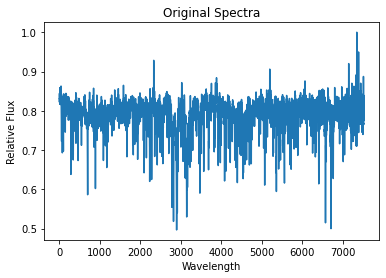

In [23]:
#x[1] = x[1] * reduced_maximum
print(x[0])

plt.title('Original Spectra')
plt.xlabel('Wavelength')
plt.ylabel('Relative Flux')
# 7514 data points for each spectra
plt.plot(x[0].cpu().numpy())
plt.show()

tensor([0.8474, 0.8739, 0.8995,  ..., 0.9009, 0.8953, 0.8856], device='cuda:0')


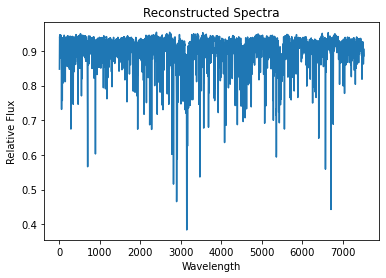

In [24]:
#x_hat[1] = x_hat[1] * reduced_maximum

print(x_hat[0])

plt.title('Reconstructed Spectra')
plt.xlabel('Wavelength')
plt.ylabel('Relative Flux')
# 7514 data points for each spectra
plt.plot(x_hat[0].cpu().numpy())
plt.show()